# STAT 301 Final Report


**Assignment Title:** Modeling Online Purchase Behavior with Browsing and Session Features

**Group Number:** 26  

**Members:**  
- Ignacio Mijares  
- Hannah Li  
- Daniel Pliego Mier (29619889)  
- Nima Motieifard (66492497)

**Course:** STAT 301  
**Due Date:** Sep 6, 2025


Load libraries and get data:

In [19]:
# Run this cell before continuing.
library(tidyverse)
library(dplyr)
library(repr)
library(infer)
library(cowplot)
library(broom)
library(GGally)
library(AER)
library(glmnet)
library(car)
library(MASS)
library(caret)
library(patchwork)

**Section 0: TA feedback**

I got almost full marks in stage 1 of the project other than some marks taken off because of typos and 10% deduction for subimiting on the wrong place. I will go through stage 1 and fix some of the typos, I'll mark the fixes in bold but no major changes will be done to my submission of stage 1.  

The TA feedback and grade: 
-10% for submitting into the wrong group page (-2.94)
26.46/30

**Section 1**

*Source and information*

The dataset used in this project is the Online Shoppers Purchasing Intention Dataset, obtained from the UCI Machine Learning Repository

The dataset was made on 2018 and consists of 12330 observations of users in an online shopping __website__, each observation corresponds to a single user session and it contains no missing values. The variables on the dataset are the following:

- `Administrative`: __integer__ representing number of administrative pages visited

- `Administrative_Duration`:  __integer__ representing total time passed in administrative pages

- `Informational`:  __integer__ representing number of informational pages visited
 
 - `Informational_Duration`:  __integer__ representing total time passed in informational pages

 - `ProductRelated	`:  __integer__ representing number of product related pages visited

 -  `ProductRelated_Duration`:  __integer__ representing total time passed in product related pages

 -  `BounceRates`: __continuous__ variable representing how quickly users leave pages (Google Analytics metric).

 -   `ExitRates`: __continuous__ variable representing how quickly users leave the website (Google Analytics metric).

 -  `PageValues`:  __integer__ representing estimated value of a page (Google Analytics metric).

   -  `SpecialDay`:  __integer__ representing the proximity of the date __accessed__ to a "special" day (valentines, christmas, etc).

-  `Month`: categorical variable representing each month

-  `OperatingSystems`: integer variable representing different operating systems (dataset description says this is an integer, I think it could be used as a categorical variable although there is no information about what each integer represents)

-  `Browser`: integer variable representing different browsers used (dataset description says this is an integer, I think it could be used as a categorical variable although there is no information about what each integer represents)

-  `Region`: integer variable representing which region the user is located (dataset description says this is an integer, I think it could be used as a categorical variable although there is no information about what each integer represents)

-  `TrafficType`: integer variable representing different __traffic types__ (dataset description says this is an integer, I think it could be used as a categorical variable although there is no information about what each integer represents)

-  `VisitorType`: categorical variable representing if a user is a returning user or a new user.

- `Weekend`: Binary categorical variable representing if this observation was on the weekend.

- `Revenue`: Binary categorical variable with TRUE if the user completed a purchase, FALSE otherwise.


Sakar, C. & Kastro, Y. (2018). Online Shoppers Purchasing Intention Dataset [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5F88Q.



*Pre selection of variables*

I will not use the variables Browser, Region and TrafficType. This is because on the page of the dataset it says that they are integers, however I think they represent categories and I was not able to find which category each integer represents so in the case one of __these__ categories turned out to be important we could not know what it represents.

**Section 2**

*Scientific Question*

I want to examine the association between whether an online user makes a purchase (response) and predictors related to their browsing behavior (e.g., number of visits and time spent on administrative, informational, and product-related pages), as well as temporal and user characteristics (e.g., month, proximity to a special day, and whether the visitor is a returning user).

This means that the response variable is the Revenue variable which is TRUE if the user completed a purchase and FALSE otherwise, this means I will use a __Logistic__ model.

This project is based on prediction,  I want to be able to predict if a user is going to make a __purchase__ or not based on the explanatory variables above. 

*Response Variable*

The response variable is Revenue, which is TRUE if the user completed a purchase and FALSE otherwise. Since the response is binary, a logistic regression model will be used.

*Explain whether your question is focused on prediction, inference, or both*

This project mainly focuses on prediction, the goal is to predict whether a user will make a purchase based on the explanatory variables listed above. However, some inference will also be explored to understand which factors most strongly influence purchasing behavior.

**Section 3**

*Exploratory Data Analysis and Visualization*

The dataset was loaded into the same folder as this project file and no data cleaning other than removing the 3 variables that I stated I was not going to use since the dataset contains no missing valus.

In [20]:
data <- read.csv("project_data.csv")
data <- subset(data, select = -c(Browser, Region, TrafficType))
head(data)
nrow(data)


# Make sure categorical variables are treated as factors
data <- data |>
  mutate(
    Month = factor(Month),
    VisitorType = factor(VisitorType),
    Weekend = factor(Weekend),
    OperatingSystems = factor(OperatingSystems),
    Revenue = factor(Revenue, levels = c("FALSE", "TRUE"))  # ensure 0/1 order
  )

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,VisitorType,Weekend,Revenue
,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>,<lgl>,<lgl>
1,0,0,0,0,1,0.000000,0.20000000,0.2000000,0,0,Feb,1,Returning_Visitor,FALSE,FALSE
2,0,0,0,0,2,64.000000,0.00000000,0.1000000,0,0,Feb,2,Returning_Visitor,FALSE,FALSE
3,0,0,0,0,1,0.000000,0.20000000,0.2000000,0,0,Feb,4,Returning_Visitor,FALSE,FALSE
4,0,0,0,0,2,2.666667,0.05000000,0.1400000,0,0,Feb,3,Returning_Visitor,FALSE,FALSE
5,0,0,0,0,10,627.500000,0.02000000,0.0500000,0,0,Feb,3,Returning_Visitor,TRUE,FALSE
6,0,0,0,0,19,154.216667,0.01578947,0.0245614,0,0,Feb,2,Returning_Visitor,FALSE,FALSE


[1] 12330

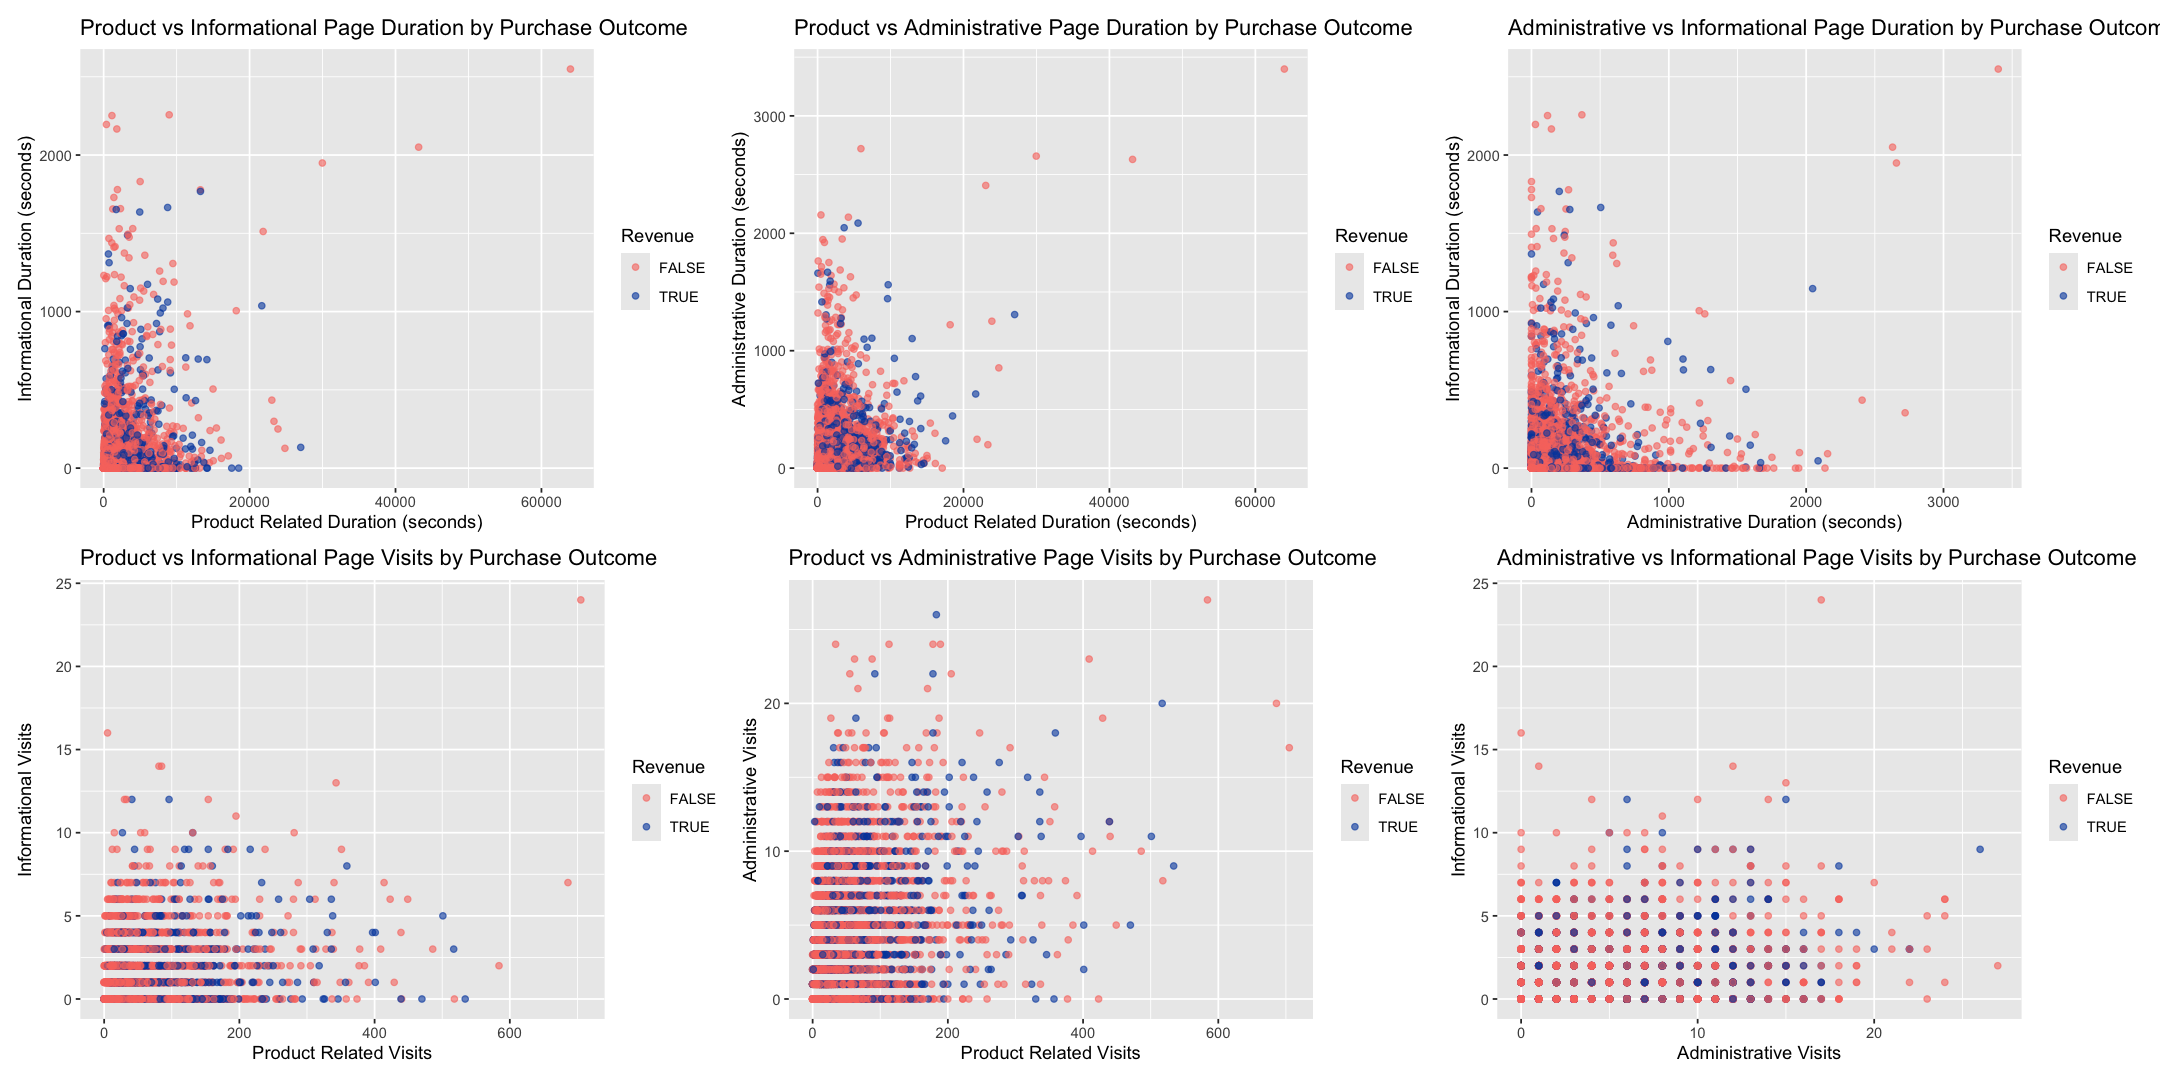

In [21]:
pvi_d <- ggplot(data, aes(x = ProductRelated_Duration, 
                 y = Informational_Duration, 
                 color = Revenue)) +
  geom_point(alpha = 0.6) +
  scale_color_manual(values = c("TRUE" = "#0047AB", "FALSE" = "#F8766D")) + 
  labs(
    title = "Product vs Informational Page Duration by Purchase Outcome",
    x = "Product Related Duration (seconds)",
    y = "Informational Duration (seconds)",
    color = "Revenue"
  )

pva_d <- ggplot(data, aes(x = ProductRelated_Duration, 
                 y = Administrative_Duration, 
                 color = Revenue)) +
  geom_point(alpha = 0.6) +
  scale_color_manual(values = c("TRUE" = "#0047AB", "FALSE" = "#F8766D")) + 
  labs(
    title = "Product vs Administrative Page Duration by Purchase Outcome",
    x = "Product Related Duration (seconds)",
    y = "Administrative Duration (seconds)",
    color = "Revenue"
  )

avi_d <- ggplot(data, aes(x = Administrative_Duration, 
                 y = Informational_Duration, 
                 color = Revenue)) +
  geom_point(alpha = 0.6) +
  scale_color_manual(values = c("TRUE" = "#0047AB", "FALSE" = "#F8766D")) + 
  labs(
    title = "Administrative vs Informational Page Duration by Purchase Outcome",
    x = "Administrative Duration (seconds)",
    y = "Informational Duration (seconds)",
    color = "Revenue"
  )
  
pvi <- ggplot(data, aes(x = ProductRelated, 
                 y = Informational, 
                 color = Revenue)) +
  geom_point(alpha = 0.6) +   
  scale_color_manual(values = c("TRUE" = "#0047AB", "FALSE" = "#F8766D")) + 
  labs(
    title = "Product vs Informational Page Visits by Purchase Outcome",
    x = "Product Related Visits",
    y = "Informational Visits",
    color = "Revenue"
  )

pva <- ggplot(data, aes(x = ProductRelated, 
                 y = Administrative, 
                 color = Revenue)) +
  geom_point(alpha = 0.6) +   
  scale_color_manual(values = c("TRUE" = "#0047AB", "FALSE" = "#F8766D")) + 
  labs(
    title = "Product vs Administrative Page Visits by Purchase Outcome",
    x = "Product Related Visits",
    y = "Administrative Visits",
    color = "Revenue"
  )


avi <- ggplot(data, aes(x = Administrative, 
                 y = Informational, 
                 color = Revenue)) +
  geom_point(alpha = 0.6) + 
  scale_color_manual(values = c("TRUE" = "#0047AB", "FALSE" = "#F8766D")) + 
  labs(
    title = "Administrative vs Informational Page Visits by Purchase Outcome",
    x = "Administrative Visits",
    y = "Informational Visits",
    color = "Revenue"
  )

options(repr.plot.width = 18, repr.plot.height = 9)
(pvi_d | pva_d | avi_d) / (pvi | pva | avi)

Our first visualization shows 6 scatterplots, they each show whether a purchase was made on each observation along with the duration of time (top row) or number of pages visits (bottom row) for each of the 3 types of page the dataset provides us with (Informational, Product Related, Administrative).

We are interested in excploring if there is a difference between the observations where a purchase was made and the time spent on each page type / number of types different page types where visited as one would expect higher durations of times / pages visited to lead to a higher chance of purchase. However the visualizations show no clear pattern, making for a more interesting exploration of the association between variables. 

Ignoring unknown labels:
• colour : "Revenue"
Ignoring unknown labels:
• colour : "Revenue"


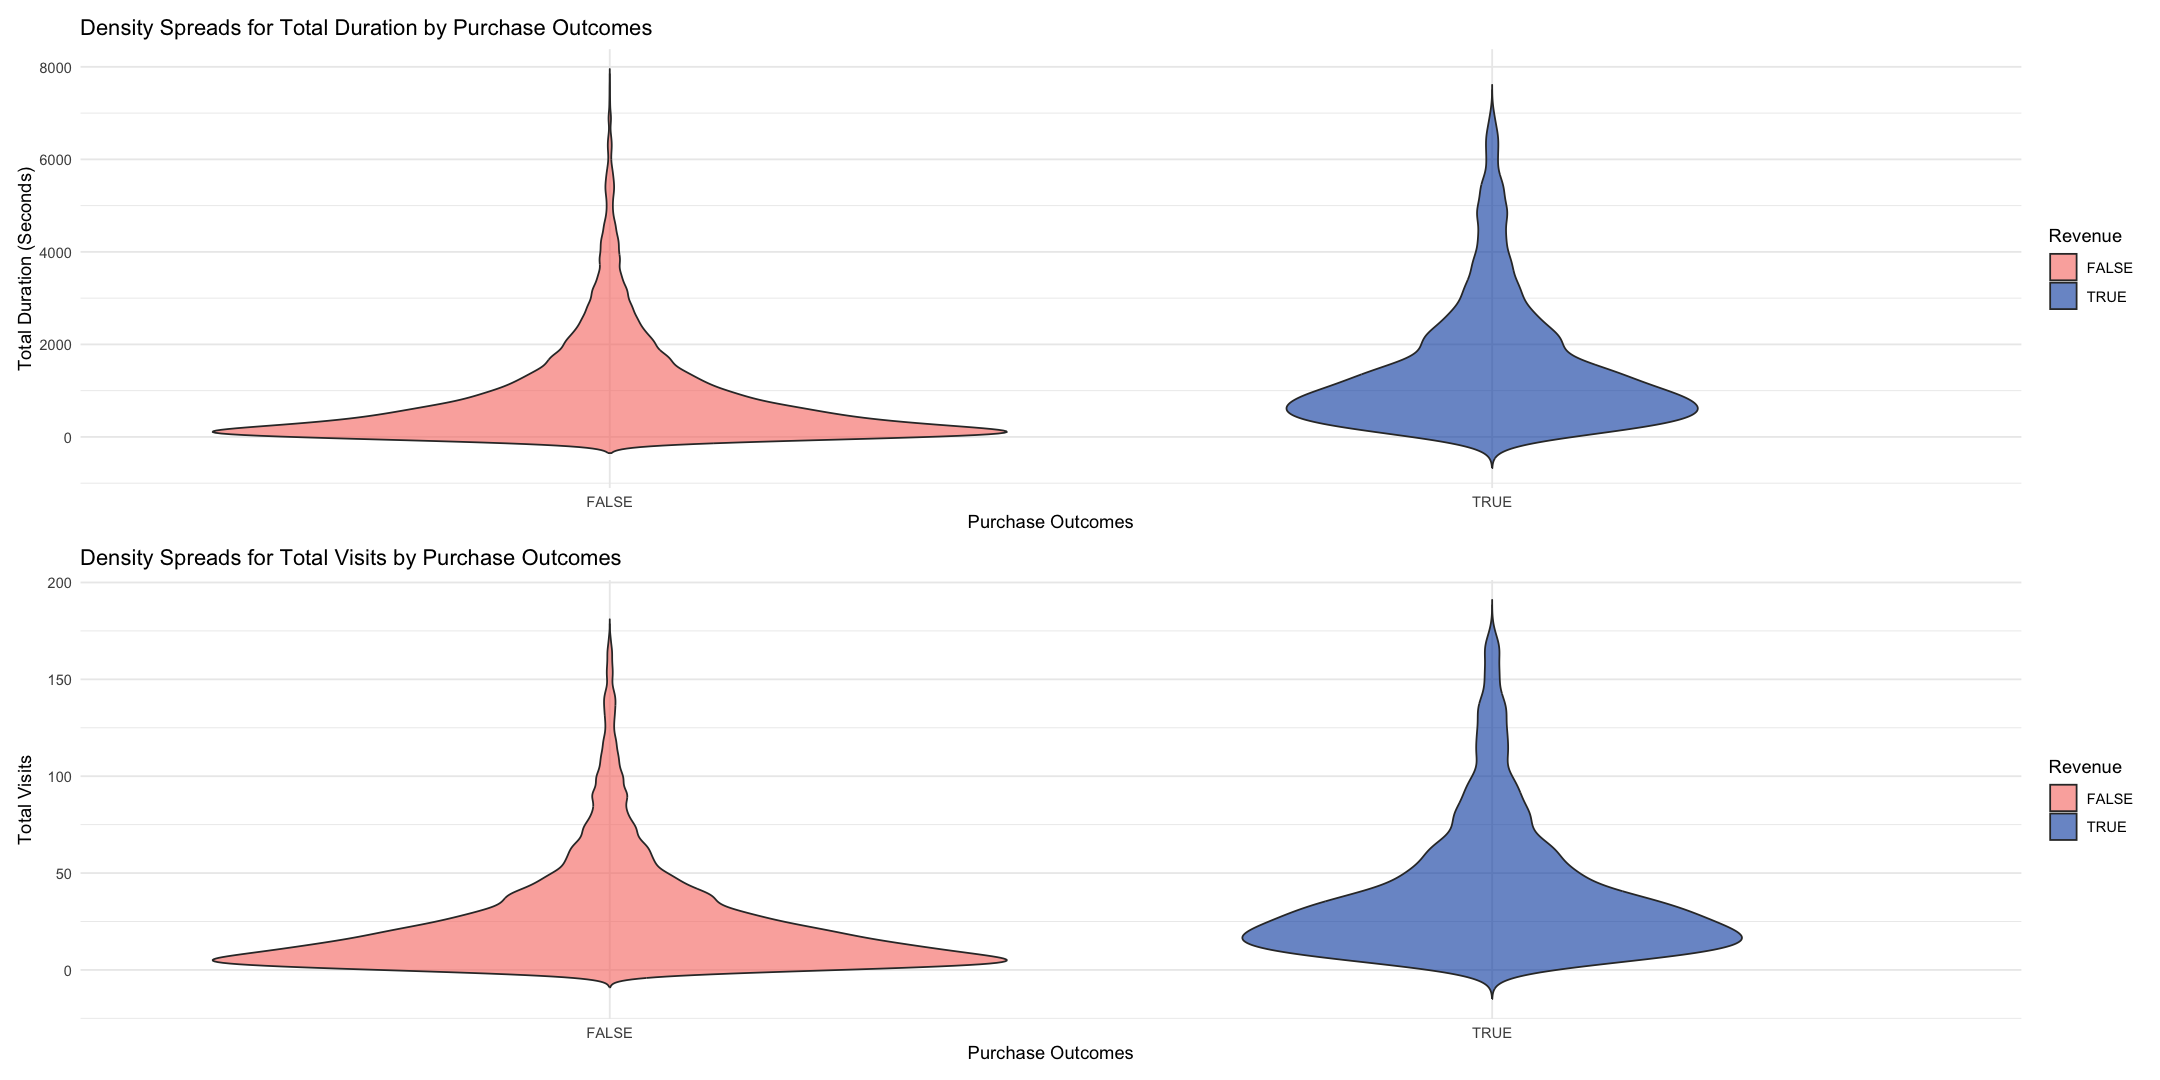

In [24]:
# For the sake of best visualizing our data we dropped outliers using the Z-Score outlier rule 
# (more than 3 sd's away from the mean is considered an outlier)

# calculating means, sd's, and cutoff values
mean_pr_d <- mean(data$ProductRelated_Duration)
sd_pr_d <- sd(data$ProductRelated_Duration)
cutoff_pr_d = mean_pr_d + 3 * sd_pr_d

mean_i_d <- mean(data$Informational_Duration)
sd_i_d <- sd(data$Informational_Duration)
cutoff_i_d = mean_i_d + 3 * sd_i_d

mean_a_d <- mean(data$Administrative_Duration)
sd_a_d <- sd(data$Administrative_Duration)
cutoff_a_d = mean_a_d + 3 * sd_a_d

mean_pr <- mean(data$ProductRelated)
sd_pr <- sd(data$ProductRelated)
cutoff_pr = mean_pr + 3 * sd_pr

mean_i <- mean(data$Informational)
sd_i <- sd(data$Informational)
cutoff_i = mean_i + 3 * sd_i

mean_a <- mean(data$Administrative)
sd_a <- sd(data$Administrative)
cutoff_a = mean_a + 3 * sd_a

# filtering them out of the data
data_clean <- data %>%
  filter(ProductRelated_Duration <= cutoff_pr_d) %>%
  filter(Informational_Duration <= cutoff_i_d) %>%
  filter(Administrative_Duration <= cutoff_a_d) %>%
  filter(ProductRelated <= cutoff_pr) %>%
  filter(Informational <= cutoff_i) %>%
  filter(Administrative <= cutoff_a)

# creating the total values
data_clean <- data_clean %>%
    mutate(
        TotalDuration = Administrative_Duration + Informational_Duration + ProductRelated_Duration,
        TotalVisits = Administrative + Informational + ProductRelated
    )

# violin plots
v1 <- ggplot(data_clean, aes(x = Revenue, y = TotalDuration, fill = Revenue)) +
  geom_violin(alpha = 0.6, trim = FALSE) +
  scale_fill_manual(values = c("TRUE" = "#0047AB", "FALSE" = "#F8766D")) +
  theme_minimal() + 
  labs(
    title = "Density Spreads for Total Duration by Purchase Outcomes",
    x = "Purchase Outcomes",
    y = "Total Duration (Seconds)",
    color = "Revenue"
  )

v2 <- ggplot(data_clean, aes(x = Revenue, y = TotalVisits, fill = Revenue)) +
  geom_violin(alpha = 0.6, trim = FALSE) +
  scale_fill_manual(values = c("TRUE" = "#0047AB", "FALSE" = "#F8766D")) +
  theme_minimal() + 
  labs(
    title = "Density Spreads for Total Visits by Purchase Outcomes",
    x = "Purchase Outcomes",
    y = "Total Visits",
    color = "Revenue"
  )

(v1) / (v2)


Our second visualization explores density spreads by purchase outcomes for both duration and total visit metrics. The violin plots show how purchase outcomes were distributed across the summed values for each instance.

We are interested in exploring whether there are any discrepancies in where TRUE and FALSE outcomes are most likely to occur. Our visualizations show that the majority of TRUE outcomes occur after slightly more seconds/page visits than the majority of FALSE purchase outcomes. Although TRUE outcomes appear more frequently than FALSE outcomes at the extreme upper end, the difference is not substantial.

Note that, to best represent the visualization, we used the Z-score outlier rule to drop any observations more than 3 standard deviations from the mean.

**Method and Plan**

The response variable for this question is binary. Therefore we will use Logistic Regression to try to predict if a user will make a purchase or not. Logistic Regression assumes that the response follows a Bernoulli distrbution and in practice this might not always be the case. 

The goal is to find a subset of variables which can hopefully get better predictions. To do this, we will compare two different models, a Logistic Regression using Lasso regularization for the model to perform feature selection, and a model fitted with stepAIC(). We will use stepAIC() and not regsubsets() since the model data contains a few categorical variables. 
We also want to note that using Lasso regularization with categorical variables performs feature selection using the dummy variables rather than the entire categorical variable just like stepAIC() does.

Before fitting either of the models we will look at the multicollinearity on the data, again since we are working with categorical variables we will use GVIF for this.

Here we will check for multicollinearity on the data.

In [23]:
# For reproducibility
set.seed(2002)

# Fit a standard logistic regression
logit_model <- glm(
  Revenue ~ .,    
  data = data,
  family = binomial
)

# Compute GVIF
gvif_values <- vif(logit_model)
gvif_values

,GVIF,Df,GVIF^(1/(2*Df))
Administrative,1.815047,1,1.347237
Administrative_Duration,1.674391,1,1.293983
Informational,1.839241,1,1.356186
Informational_Duration,1.698229,1,1.303161
ProductRelated,4.899833,1,2.213557
ProductRelated_Duration,4.856140,1,2.203665
BounceRates,2.162272,1,1.470466
ExitRates,2.320391,1,1.523283
PageValues,1.079825,1,1.039146
SpecialDay,1.262652,1,1.123678


None of the observed GVIF's are above 5, therefore multicollinearity is not an issue with the data and we do not have to remove any of the variables.

**Code and Results**

First we will split the data into a testing set and a validation set such that we can test how the better model performs on unseen data.

In [16]:
set.seed(2002)

# Make sure categorical variables are treated as factors
data <- data |>
  mutate(
    Month = factor(Month),
    VisitorType = factor(VisitorType),
    Weekend = factor(Weekend),
    OperatingSystems = factor(OperatingSystems),
    Revenue = factor(Revenue, levels = c("FALSE", "TRUE"))  # ensure 0/1 order
  )

# 80% of the data will be used for training
train_idx <- sample(seq_len(nrow(data)), size = 0.8 * nrow(data))
train <- data[train_idx, ]
test  <- data[-train_idx, ]

# Create model matrices for glmnet()
y_train <- ifelse(train$Revenue == "TRUE", 1, 0)
X_train <- model.matrix(Revenue ~ ., data = train)[, -1]

y_test <- ifelse(test$Revenue == "TRUE", 1, 0)
X_test <- model.matrix(Revenue ~ ., data = test)[, -1]

Now that we have split the data we can fit both models, we will train the models using only the training set, use cross-validation with 5 folds on both cases and compare the accuracy of the models, the better model will be re-fit using all the training data and then tested on the unseen testing set. 

We are using cross-validation on the stepAIC() model since we want to keep a fair comparisson to the Lasso model which is performing cross-validation to find the best value of lambda. 

We arbitrarily choose to use backward selection on the stepAIC() model. Because the number of explanatory variables is smaller than the number of observations, both backward and forward selection work well, the choice between them does not affect the procedure significantly.

In [17]:
set.seed(2002)

# Predefine folds for CV, random
foldid <- sample(rep(1:5, length.out = length(y_train)))

# First will do cross-validation on stepAIC()
stepAIC_preds <- numeric(length(y_train))

# There were warning generated by stepAIC() due to prob. 0 or 1
suppressWarnings({
for (i in 1:5) {
  train_idx <- which(foldid != i)
  test_idx  <- which(foldid == i)
  
  train_data <- data.frame(Revenue = y_train[train_idx], X_train[train_idx, , drop = FALSE])
  test_data  <- data.frame(Revenue = y_train[test_idx], X_train[test_idx, , drop = FALSE])
  
  # Fit full logistic regression
  full_model <- glm(Revenue ~ ., data = train_data, family = binomial)
  
  # Stepwise backward selection
  step_model <- stepAIC(full_model, direction = "backward", trace = FALSE)
  
  # Predict on test fold
  stepAIC_preds[test_idx] <- predict(step_model, newdata = test_data, type = "response")
}
    })

stepAIC_class <- ifelse(stepAIC_preds > 0.5, 1, 0)
cv_accuracy_stepAIC <- mean(stepAIC_class == y_train)

# Cross-validation on lasso
cvfit <- cv.glmnet(
  x = X_train,
  y = y_train,
  family = "binomial",
  alpha = 1,
  foldid = foldid   # use same folds as stepAIC
)

lasso_preds <- predict(cvfit, newx = X_train, s = "lambda.1se", type = "response")
lasso_class <- ifelse(lasso_preds > 0.5, 1, 0)
cv_accuracy_lasso <- mean(lasso_class == y_train)

# compare the accuracies
cat("Accuracies on test data:\n")
cat("  • stepAIC model accuracy:", round(cv_accuracy_stepAIC, 4), "\n")
cat("  • LASSO model accuracy:  ", round(cv_accuracy_lasso, 4), "\n")

Accuracies on test data:
  • stepAIC model accuracy: 0.8845 
  • LASSO model accuracy:   0.8811 


We can see that both models achieve very similar accuracy on the predictions, with the stepAIC() model performing a little better. Since the stepAIC() model performed better, we will train a new model using the entire training set and then use this model to see how it performs on the testing set. We will also examine which predictors are chosen by the model.

In [18]:
set.seed(2002)

train_df <- data.frame(Revenue = y_train, X_train)

# Fit full logistic regression
full_model <- glm(Revenue ~ ., data = train_df, family = binomial)

suppressWarnings({
# Backward stepwise selection
step_model <- stepAIC(full_model, direction = "backward", trace = FALSE)
    })

# Predict on the test set
test_df <- data.frame(X_test)

pred_prob_stepAIC  <- predict(step_model, newdata = test_df, type = "response")
pred_class_stepAIC <- ifelse(pred_prob_stepAIC > 0.5, 1, 0)

# Test accuracy
accuracy_stepAIC <- mean(pred_class_stepAIC == y_test)

cat("The prediction accuracy on the test set is", 
    round(accuracy_stepAIC, 4), "\n")

# Get selected variables
coef_step <- coef(step_model)

# Get predictor names (excluding the intercept)
predictor_names <- names(coef_step)[names(coef_step) != "(Intercept)"]

# Put into a simple data frame
selected_predictors_df <- data.frame(
  Predictor = predictor_names
)

print(selected_predictors_df)

The prediction accuracy on the test set is 0.8873 
                      Predictor
1                 Informational
2                ProductRelated
3       ProductRelated_Duration
4                     ExitRates
5                    PageValues
6                      MonthDec
7                      MonthFeb
8                      MonthMar
9                      MonthMay
10                     MonthNov
11            OperatingSystems3
12 VisitorTypeReturning_Visitor


The results align with what we expect. The model performed feature selection and chose a small subset of features that achieved a very high accuracy on unseen data, correctly predicting 88% of the observations on the test set.

We typically expect the model to perform worse on the test set compared to the validation set. This was not the case here, the prediction accuracy was slightly higher on the testing set. Since the improvement is so small, this difference is likely due to chance, but it is still worth noting.

The resulting model includes 12 predictors, some of which are dummy variables for the explanatory variables Month, VisitorType, and OperatingSystems. This is expected when utilizing stepAIC(). Overall, the predictive ability of this model is very good, correctly predicting whether a user will make a purchase or not with more than 88% accuracy on users not seen during training.